<a href="https://colab.research.google.com/github/nsoma97/conv_ai/blob/main/Conversational_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependenciák telepítése

In [ ]:
!pip install rasa==1.10.3
!pip install nest_asyncio==1.3.3
!pip install https://github.com/oroszgy/spacy-hungarian-models/releases/download/hu_core_ud_lg-0.3.1/hu_core_ud_lg-0.3.1-py3-none-any.whl  

     |████████████████████████████████| 512kB 5.2MB/s 
     |████████████████████████████████| 512kB 7.7MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 993kB 12.3MB/s 
     |████████████████████████████████| 112kB 22.1MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 419kB 19.0MB/s 
     |████████████████████████████████| 3.2MB 20.7MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 348kB 45.0MB/s 
     |████████████████████████████████| 184kB 43.2MB/s 
     |████████████████████████████████| 133kB 48.3MB/s 
     |████████████████████████████████| 5.1MB 40.6MB/s 
     |████████████████████████████████| 1.3MB 51.2MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 3.0MB 35.7MB/s 
     |████████████████████████████████| 983kB 51.6MB/s 
    

ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: nest-asyncio 1.5.1
    Uninstalling nest-asyncio-1.5.1:
      Successfully uninstalled nest-asyncio-1.5.1
     |████████████████████            | 834.1MB 1.2MB/s eta 0:06:43tcmalloc: large alloc 1147494400 bytes == 0x56226804a000 @  0x7fc7937d8615 0x56222f98906c 0x56222fa68eba 0x56222f98be8d 0x56222fa7d99d 0x56222f9fffe9 0x56222f9fab0e 0x56222f98d77a 0x56222f9ffe50 0x56222f9fab0e 0x56222f98d77a 0x56222f9fc86a 0x56222fa7e7c6 0x56222f9fbee2 0x56222fa7e7c6 0x56222f9fbee2 0x56222fa7e7c6 0x56222f9fbee2 0x56222fa7e7c6 0x56222fb00431 0x56222fa61049 0x56222f9cbc84 0x56222f98c8e9 0x56222fa00ade 0x56222f98d69a 0x56222f9fba45 0x56222f9fae0d 0x56222f98d77a 0x56222f9fba45 0x56222f98d69a 0x56222f9fba45
     |█████████████████████████▎      | 1055.7MB 1.3MB/s eta 0:03:40tcmalloc: large alloc 1434370048 bytes == 0x5622ac6a0000 @  0x7fc7937d8615 0x56222

In [ ]:
!python3 -m spacy link hu_core_ud_lg hu

✔ Linking successful
/usr/local/lib/python3.7/dist-packages/hu_core_ud_lg -->
/usr/local/lib/python3.7/dist-packages/spacy/data/hu
You can now load the model via spacy.load('hu')


In [ ]:
import os
import rasa
from rasa.cli.scaffold import create_initial_project
from rasa.jupyter import chat
import nest_asyncio

nest_asyncio.apply()

# Rasa demo chatbot

In [ ]:
project = "test-chatbot"
create_initial_project(project)

os.chdir(project)

In [ ]:
%ls

actions.py  credentials.yml  domain.yml     __init__.py   tests/
config.yml  data/            endpoints.yml  __pycache__/




* **actions.py**: itt implementálható egyedi üzleti logika, adatbázis lekérdezés, API hívások megvalósítása, stb.
* **credentials.yml** és **endpoints.yml**: beállítható külső integráció (Slack, Facebook, stb.) a chatbothoz, az elérési pontok megadása
* **domain.yml**: definiálja az 'univerzumot', melyben a chatbotunk működik. Itt soroljuk fel, hogy milyen felhasználói szándékokat kezelünk, mik az entitásaink, megadhatjuk a lehetséges válaszokat, slotokat, stb...
* **tests/**: ebben a mappában teszteseteket írhatunk a chatbot működésének kiértékelésére
* **config.yml**: itt határozzuk meg a chatbot által használt NLU pipeline-t, azaz hogy pontosan milyen NLP modulokat alkalmazunk a felhasználó által megaadott bemeneti szövegre
* **data/**: itt található a tanítóadatunk
  - **nlu.md**: intentekhez sorolt, entitásokkal annotált tanítómondatok, ebből tanul az NLU model (Rasa NLU)
  - **stories.md**: itt olyan 'sztorikat' írunk le absztrakt formában, amelyek a felhasználóval lejátszódhatnak, ebből tanul a dialógusmodell (Rasa Core)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
config = "config.yml"
training_files = "data/"
domain = "domain.yml"
output = "models/"

model_path = rasa.train(domain, config, [training_files], output)
print(model_path)

Training Core model...


Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 125.93it/s, # actions=16]
Processed actions: 16it [00:00, 703.54it/s, # examples=16]
Processed trackers: 100%|██████████| 231/231 [00:08<00:00, 27.14it/s, # actions=126]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rasa/utils/tensorflow/model_data.py:386: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_data[k].append(np.concatenate(np.array(v)))
Epochs: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s, t_loss=0.104, loss=0.029, acc=1.000]


Core model training completed.
Training NLU model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

/usr/local/lib/python3.7/dist-packages/rasa/utils/common.py:363: UserWarning: You specified 'DIET' to train entities, but no entities are present in the training data. Skip training of entities.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rasa/utils/tensorflow/model_data.py:386: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_data[k].append(np.concatenate(np.array(v)))
Epochs: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s, t_loss=1.502, i_loss=0.113, i_acc=1.000]


NLU model training completed.
Your Rasa model is trained and saved at '/content/test-chatbot/models/20210414-074749.tar.gz'.
models/20210414-074749.tar.gz


In [ ]:
endpoints = 'endpoints.yml'
chat(model_path, endpoints)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has

KeyboardInterrupt: ignored

# Saját magyarul beszélő chatbot

In [ ]:
%cd /content
%mkdir our-very-own-chatbot
%cd our-very-own-chatbot
%mkdir data

/content
/content/our-very-own-chatbot


## Tanítóadat definiálása

In [ ]:
%%writefile data/nlu.md

## intent: greeting
    - szia
    - üdv
    - jó napot
    - jó napot kívánok!
    - hello
    - jó estét!
## intent: closure
    - viszlát
    - köszönöm, viszlát
    - köszönöm a segítséget
    - viszontlátásra
    - kössz viszlát
## intent: balance
    - mennyi pénz van a számlámon?
    - mennyi pénzem van?
    - arra vagyok kiváncsi hogy mennyi az egyenlegem
    - hány forint van a számlámon?
    - hány forint az egyenlegem?
    - mutasd az egyenlegem
    - mutasd hogy mennyim van
## intent: credit
    - hitelt szeretnék felvenni
    - kölcsönt szeretnék
    - kölcsönre lenne szükségem
    - banki hitelre lenne szükségem
    - hitelt szeretnék felvenni egy lakásra
    - kölcsönt vennék fel
## intent: freeze_card
    - ellopták a kártyám
    - elveszett a bankkártyám
    - a bankkártyám eltűnt
    - nincs meg a bankkártyám
    - szeretném zárolni a kártyám
    - szeretném befagyasztani a kártyám
    - be szeretném fagyasztani a kártyám
## intent: atm_location
    - hol van a legközelebbi atm?
    - bankautomatát keresek
    - egy automatát keresek
    - mutass egy közeli automatát
    - pénzt szeretnék felvenni
    - készpénzt szeretnék felvenni
    - készpénzre van szükségem
    - hol tudok készpénzt felvenni?
    - mutasd az atmeket
    - egy atm-et keresek
    - hol találok automatát?
    - hol a legközelebbi atm?
    - egy atm kéne
## intent: bank_location
    - hol a legközelebbi fiókotok?
    - egy bankfiókot keresek
    - hol vannak bankfiókjaitok?
    - mutasd a bankok listáját
    - egy bankot keresek
    - legközelebbi bank?
    - közeli bankok listája?
    - hol tudok ügyet intézni?
    - hol található bankfiók?
    - bankfiók helyet keresek
## intent: location_open
    - mi a [szatymazi](bank_location) fiók nyitvatartása?
    - mikor nyit a [szegedi](bank_location) bankotok?
    - mikor tudék bemenni [makón](bank_location) a bankba?
    - mi a nyitvatartási ideje a [szegeden](bank_location) lévő fióknak?
    - nyitva van holnap a [makói](bank_location) fiókuk?
    - mikor nyit holnap a bank [szegeden](bank_location)?
    - meddig van nyitva a bank [szatymazon](bank_location)?
    - mi a [szegedi](bank_location) fiók nyitvatartási ideje?
    - nyitva van még a bank [szatymazon](bank_location)?
    - bezárt már a [makói](bank_location) fiókuk?
    - meddig vannak nyitva a fiókjaik?
    - mi a nyitvatartási idejük?
    - mikor érhető el az ügyfélszolgálatuk?
    - mi az ügyfélszolgálat nyitvatartási ideje?

Writing data/nlu.md


In [ ]:
%%writefile data/stories.md

## intro
* greeting
  - utter_greeting

## credit
* greeting
  - utter_greeting
* credit
  - utter_credit
* closure
  - utter_closure

## bank_data
* greeting
  - utter_greeting
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## bank_data
* greeting
  - utter_greeting
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## freeze_card_1
* freeze_card
  - utter_freeze_card
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## freeze_card_2
* greeting
  - utter_greeting
* freeze_card
  - utter_freeze_card

## credit
* credit
  - utter_credit
* bank_location
  - utter_bank_location
* closure
  - utter_closure

Writing data/stories.md


In [ ]:
%%writefile domain.yml

entities: 
  - bank_location
intents: 
  - greeting
  - closure
  - balance
  - credit
  - freeze_card
  - atm_location
  - bank_location
  - location_open
responses: 
  utter_atm_location: 
    - text: "Az ATM-eink a következő felületen kereshetők: www.csongraditakarek.hu/atms"
  utter_bank_location: 
    - text: "Jelenleg három bankfiókkal rendelkezünk: Szegeden, Makón és Szatymazon."
  utter_closure: 
    - text: "Viszlát!"
  utter_credit: 
    - text: "Hiteligényléshez kérjük keresse fel egyik fiókunkat! Az elérhető információkról a honlapunkon tájékozódhat."
  utter_freeze_card: 
    - text: "Kártyáját azonnali hatállyal befagyasztottuk. További információért keresse ügyintézőinket."
  utter_greeting: 
    - text: "Üdvözlöm! Miben segíthetek?"

Writing domain.yml


## Modell tanítása

In [ ]:
%%writefile config.yml

language: hu

pipeline:
  - name: SpacyNLP
  - name: SpacyTokenizer
  - name: SpacyFeaturizer
  - name: CountVectorsFeaturizer
  - name: DIETClassifier
    epochs: 100
    entity_recognition: true
  - name: ResponseSelector
    epochs: 50

policies:
   - name: MemoizationPolicy
   - name: TEDPolicy
     max_history: 5
     epochs: 100

Overwriting config.yml


In [ ]:
%rm models/ -r

rm: cannot remove 'models/': No such file or directory


In [ ]:
config = "config.yml"
training_files = "data/"
domain = "domain.yml"
output = "models/"

model_path = rasa.train(domain, config, [training_files], output)
print(model_path)

/usr/local/lib/python3.7/dist-packages/rasa/core/domain.py:151: FutureWarning: No tracker session configuration was found in the loaded domain. Domains without a session config will automatically receive a session expiration time of 60 minutes in Rasa version 2.0 if not configured otherwise.
  session_config = cls._get_session_config(data.get(SESSION_CONFIG_KEY, {}))


Core stories/configuration did not change. No need to retrain Core model.
Training NLU model...


/usr/local/lib/python3.7/dist-packages/rasa/nlu/classifiers/diet_classifier.py:589: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_dense = np.array(X_dense)
/usr/local/lib/python3.7/dist-packages/rasa/nlu/classifiers/diet_classifier.py:595: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for tag_name, tag_ids in tag_name_to_tag_ids.items()
Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rasa/utils/tensorflow/model_data.py:386: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a li

NLU model training completed.
Your Rasa model is trained and saved at '/content/our-very-own-chatbot/models/20210412-193224.tar.gz'.
models/20210412-193224.tar.gz


## NLU modell kiértékelése

In [ ]:
os.environ['model_path'] = model_path.split('/')[-1]

In [ ]:
%%sh
echo $model_path

20210412-193224.tar.gz


In [ ]:
%%sh
cd models
mkdir latest_model
tar -xf $model_path -C latest_model
ls latest_model/nlu

checkpoint
component_3_CountVectorsFeaturizer.pkl
component_4_DIETClassifier.data_example.pkl
component_4_DIETClassifier.entity_tag_specs.json
component_4_DIETClassifier.index_label_id_mapping.pkl
component_4_DIETClassifier.label_data.pkl
component_4_DIETClassifier.tf_model.data-00000-of-00001
component_4_DIETClassifier.tf_model.index
metadata.json


mkdir: cannot create directory ‘latest_model’: File exists


In [ ]:
%%writefile data/test_nlu.md

## intent: greeting
    - üdvözlöm
    - hali
    - jó reggelt kívánok
    - hej
## intent: closure
    - köszönöm a segítséget, viszlát
    - viszont hallásra
    - további szép napot
    - kössz, ennyit akartam csak
## intent: balance
    - mennyi a számlaegyenlegem?
    - megtudhatom hogy hány forint van a számlámon?
    - azt szeretném tudni, hogy mennyi pénzem van
    - mennyi pénz van a kártyámon?
## intent: credit
    - banki kölcsönre van szükségem
    - lakáscélú hitel érdekelne
    - milyen törlesztőrészlettel tudnak hitelt adni?
    - kölcsönt szeretnék felvenni egy autóra
## intent: freeze_card
    - fagyasszák be a kártyám kérem
    - a bankkártyám ellopták, mit tudnánk tenni?
    - zároljuk a kártyám
    - zárolni kéne a kártyám, szerintem ellopták
## intent: atm_location
    - mutass egy közeli atm-et
    - egy bank automatát keresek ahol pénzt vehetek fel
    - bankautomatát keresek
    - hol vannak atmek?
## intent: bank_location
    - mutass egy közeli bankot
    - hol vannak fiókjai a banknak?
    - hol találom a legközelebbi fiókot?
    - bankfiókot keresek
## intent: location_open
    - milyen idősávban tart nyitva a bank [szegeden](bank_location)?
    - a [makói](bank_location) fiók nyitvarartása érdekelne
    - most zárva taart épp a [szatymazi](bank_location) fiók?
    - a [makói](bank_location) nyitva van épp?

Overwriting data/test_nlu.md


In [ ]:
evaluation_output = rasa.nlu.test(data_path='data/test_nlu.md', model_path='models/latest_model/nlu')

100%|██████████| 32/32 [00:00<00:00, 53.33it/s]


In [ ]:
import pandas as pd

eval_df = pd.DataFrame(evaluation_output['intent_evaluation']['predictions'])
eval_df

,text,intent,predicted,confidence
0,üdvözlöm,greeting,greeting,0.998674
1,hali,greeting,greeting,0.999213
2,jó reggelt kívánok,greeting,greeting,0.998445
3,hej,greeting,greeting,0.999105
4,"köszönöm a segítséget, viszlát",closure,closure,0.994975
5,viszont hallásra,closure,closure,0.931273
6,további szép napot,closure,closure,0.946091
7,"kössz, ennyit akartam csak",closure,closure,0.965779
8,mennyi a számlaegyenlegem?,balance,balance,0.996252
9,megtudhatom hogy hány forint van a számlámon?,balance,balance,0.999960


In [ ]:
print(evaluation_output['intent_evaluation']['report'])

               precision    recall  f1-score   support

       credit       1.00      1.00      1.00         4
      balance       1.00      1.00      1.00         4
bank_location       1.00      1.00      1.00         4
     greeting       1.00      1.00      1.00         4
location_open       1.00      1.00      1.00         4
  freeze_card       1.00      1.00      1.00         4
      closure       1.00      1.00      1.00         4
 atm_location       1.00      1.00      1.00         4

     accuracy                           1.00        32
    macro avg       1.00      1.00      1.00        32
 weighted avg       1.00      1.00      1.00        32



Confusion matrix, without normalization
[[4 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 4]]


<Figure size 432x288 with 0 Axes>

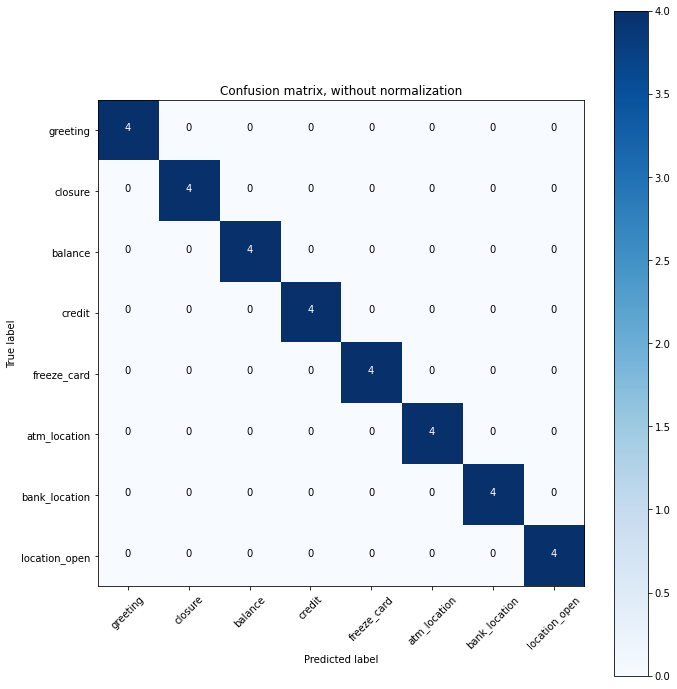

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_true = eval_df.intent.tolist()
y_pred = eval_df.predicted.tolist()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=list(eval_df.intent.unique()))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(eval_df.intent.unique()),
                      title='Confusion matrix, without normalization')

In [ ]:
endpoints = 'endpoints.yml'
chat(model_path, endpoints)

KeyboardInterrupt: ignored